# Exercise 1: Solving a 2D motion planning problem by PRM

Question: Implement the PRM algorithm described earlier to solve this problem instance. Generate other query instances and environment instances and test your algorithm.

Hint: you may use the function env.check_collision(x,y)
, which returns True if the point (x,y) is contained within a triangular obstacles, False otherwise.

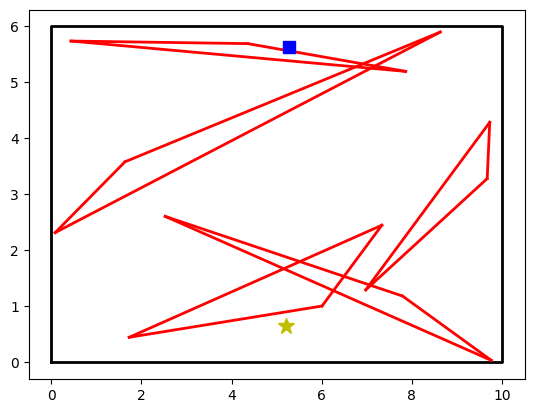

In [1]:
import numpy as np
import pylab as pl
import sys
sys.path.append('osr_examples/scripts/')
import environment_2d
pl.ion()
np.random.seed(4)
env = environment_2d.Environment(10, 6, 5)
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)

Figure 17. A 2D environment containing triangular obstacles (red triangles). The start and goal configurations are represented respectively by the green disk and the blue star

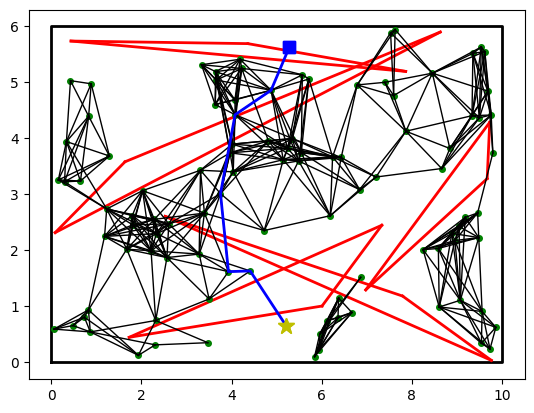

In [2]:
import networkx as nx

np.random.seed(4)

def prm_algorithm(env, n_samples, radius):
    """
    Probabilistic Roadmap (PRM) algorithm implementation
    """
    # Step 1: Sample the free space
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.rand() * env.size_x, np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            samples.append((x, y))
    
    # Step 2: Connect samples with edges within a given radius
    G = nx.Graph()
    for i, (x1, y1) in enumerate(samples):
        for j, (x2, y2) in enumerate(samples):
            if i != j and np.linalg.norm([x1 - x2, y1 - y2]) <= radius:
                if not env.check_collision((x1 + x2) / 2, (y1 + y2) / 2):
                    G.add_edge((x1, y1), (x2, y2), weight=np.linalg.norm([x1 - x2, y1 - y2]))
    
    return G, samples

def plot_prm(env, G, samples, start, goal):
    """
    Plotting the PRM graph
    """
    env.plot()
    for (x, y) in samples:
        pl.plot(x, y, 'go', markersize=4)
    for (x1, y1), (x2, y2) in G.edges():
        pl.plot([x1, x2], [y1, y2], 'k-', linewidth=1)
    env.plot_query(start[0], start[1], goal[0], goal[1])

def main():
    env = environment_2d.Environment(10, 6, 5)
    pl.clf()
    q = env.random_query()
    n_samples = 100
    radius = 1.5
    if q is not None:
        x_start, y_start, x_goal, y_goal = q
        start, goal = (x_start, y_start), (x_goal, y_goal)
        G, samples = prm_algorithm(env, n_samples, radius)
        plot_prm(env, G, samples, start, goal)
        
        # Step 3: Find path from start to goal
        if not env.check_collision(start[0], start[1]) and not env.check_collision(goal[0], goal[1]):
            G.add_node(start)
            G.add_node(goal)
            for (x, y) in samples:
                if np.linalg.norm([start[0] - x, start[1] - y]) <= radius:
                    G.add_edge(start, (x, y), weight=np.linalg.norm([start[0] - x, start[1] - y]))
                if np.linalg.norm([goal[0] - x, goal[1] - y]) <= radius:
                    G.add_edge(goal, (x, y), weight=np.linalg.norm([goal[0] - x, goal[1] - y]))
            try:
                path = nx.shortest_path(G, source=start, target=goal, weight='weight')
                path_coords = np.array(path)
                pl.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
                env.plot_query(start[0], start[1], goal[0], goal[1])  # Plot start and goal
                pl.draw()
            except nx.NetworkXNoPath:
                print("No path found")

main()

As shown above, the logic follows the prm_algorithm implementation, but some pathways seem to ignore obstacles. A refinement is needed.

To ensure that the connections and paths do not intersect with obstacles, we need to add a more comprehensive collision checking for the edges, not just the midpoint. We can use the Bresenham's line algorithm or a simple linear interpolation to generate points along the edge and check for collisions at those points.

No path found


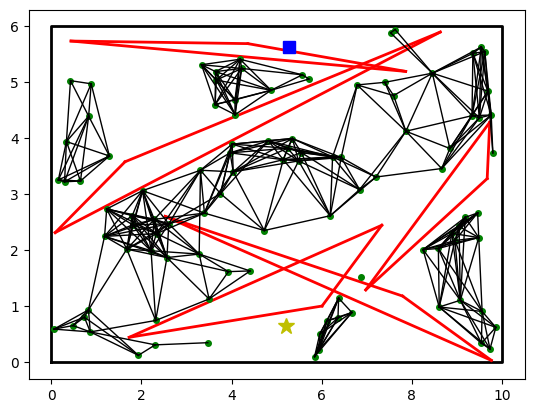

In [3]:
np.random.seed(4)

def line_collision_check(env, x1, y1, x2, y2, num_points=10):
    """
    Check if a line between (x1, y1) and (x2, y2) intersects any obstacles
    """
    x_vals = np.linspace(x1, x2, num_points)
    y_vals = np.linspace(y1, y2, num_points)
    for (x, y) in zip(x_vals, y_vals):
        if env.check_collision(x, y):
            return True
    return False

def prm_algorithm(env, n_samples=100, radius=1.5):
    """
    Probabilistic Roadmap (PRM) algorithm implementation
    """
    # Step 1: Sample the free space
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.rand() * env.size_x, np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            samples.append((x, y))
    
    # Step 2: Connect samples with edges within a given radius
    G = nx.Graph()
    for i, (x1, y1) in enumerate(samples):
        for j, (x2, y2) in enumerate(samples):
            if i != j and np.linalg.norm([x1 - x2, y1 - y2]) <= radius:
                if not line_collision_check(env, x1, y1, x2, y2):
                    G.add_edge((x1, y1), (x2, y2), weight=np.linalg.norm([x1 - x2, y1 - y2]))
    
    return G, samples

def plot_prm(env, G, samples, start, goal):
    """
    Plotting the PRM graph
    """
    env.plot()
    for (x, y) in samples:
        pl.plot(x, y, 'go', markersize=4)
    for (x1, y1), (x2, y2) in G.edges():
        pl.plot([x1, x2], [y1, y2], 'k-', linewidth=1)
    env.plot_query(start[0], start[1], goal[0], goal[1])

def main():
    env = environment_2d.Environment(10, 6, 5)
    pl.clf()
    radius = 1.5
    q = env.random_query()
    if q is not None:
        x_start, y_start, x_goal, y_goal = q
        start, goal = (x_start, y_start), (x_goal, y_goal)
        G, samples = prm_algorithm(env)
        plot_prm(env, G, samples, start, goal)
        
        # Step 3: Find path from start to goal
        if not env.check_collision(start[0], start[1]) and not env.check_collision(goal[0], goal[1]):
            G.add_node(start)
            G.add_node(goal)
            for (x, y) in samples:
                if np.linalg.norm([start[0] - x, start[1] - y]) <= radius:
                    if not line_collision_check(env, start[0], start[1], x, y):
                        G.add_edge(start, (x, y), weight=np.linalg.norm([start[0] - x, start[1] - y]))
                if np.linalg.norm([goal[0] - x, goal[1] - y]) <= radius:
                    if not line_collision_check(env, goal[0], goal[1], x, y):
                        G.add_edge(goal, (x, y), weight=np.linalg.norm([goal[0] - x, goal[1] - y]))
            try:
                path = nx.shortest_path(G, source=start, target=goal, weight='weight')
                path_coords = np.array(path)
                pl.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
                env.plot_query(start[0], start[1], goal[0], goal[1])  # Plot start and goal
                pl.draw()
            except nx.NetworkXNoPath:
                print("No path found")

main()

Will increasing the n_samples hopefully be able to find a path?

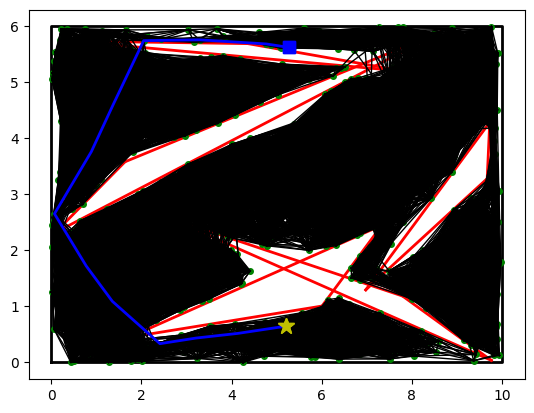

In [4]:
np.random.seed(4)

def prm_algorithm(env, n_samples=1000, radius=1.5):
    """
    Probabilistic Roadmap (PRM) algorithm implementation
    """
    # Step 1: Sample the free space
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.rand() * env.size_x, np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            samples.append((x, y))
    
    # Step 2: Connect samples with edges within a given radius
    G = nx.Graph()
    for i, (x1, y1) in enumerate(samples):
        for j, (x2, y2) in enumerate(samples):
            if i != j and np.linalg.norm([x1 - x2, y1 - y2]) <= radius:
                if not line_collision_check(env, x1, y1, x2, y2):
                    G.add_edge((x1, y1), (x2, y2), weight=np.linalg.norm([x1 - x2, y1 - y2]))
    
    return G, samples

main()

It does, though this is invalid as the line checks need to be more stringent. Let's update the collision check function and try again

No path found


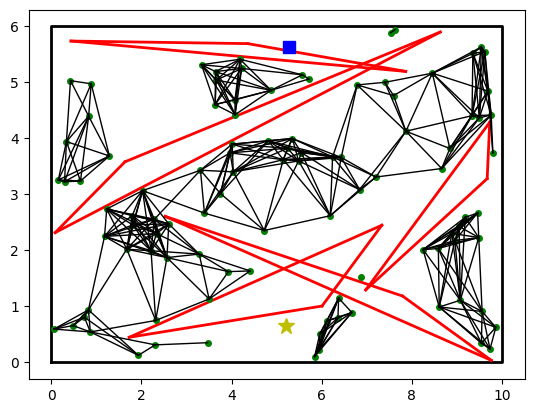

In [5]:
np.random.seed(4)

# Updated collision checks
def do_lines_intersect(p1, p2, q1, q2):
    """
    Check if line segment p1p2 intersects with line segment q1q2
    """
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    if o1 != o2 and o3 != o4:
        return True

    return False

def line_collision_check(env, x1, y1, x2, y2):
    """
    Check if a line between (x1, y1) and (x2, y2) intersects any obstacle edges
    """
    for obs in env.obs:
        vertices = [(obs.x0, obs.y0), (obs.x1, obs.y1), (obs.x2, obs.y2)]
        edges = [(vertices[i], vertices[(i + 1) % 3]) for i in range(3)]
        for (q1, q2) in edges:
            if do_lines_intersect((x1, y1), (x2, y2), q1, q2):
                return True
    return False

def prm_algorithm(env, n_samples=100, radius=1.5):
    """
    Probabilistic Roadmap (PRM) algorithm implementation
    """
    # Step 1: Sample the free space
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.rand() * env.size_x, np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            samples.append((x, y))
    
    # Step 2: Connect samples with edges within a given radius
    G = nx.Graph()
    for i, (x1, y1) in enumerate(samples):
        for j, (x2, y2) in enumerate(samples):
            if i != j and np.linalg.norm([x1 - x2, y1 - y2]) <= radius:
                if not line_collision_check(env, x1, y1, x2, y2):
                    G.add_edge((x1, y1), (x2, y2), weight=np.linalg.norm([x1 - x2, y1 - y2]))
    
    return G, samples

main()

Collision checks do appear to be better, trying with n_samples = 1000:

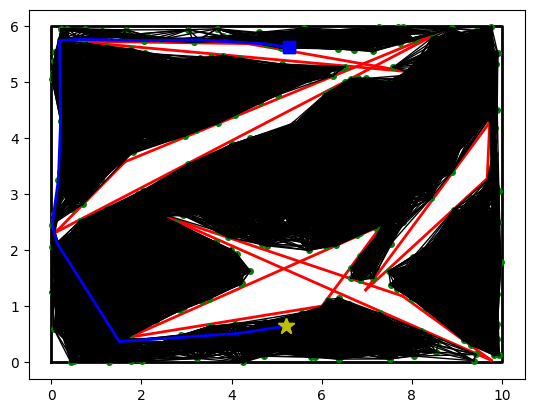

In [6]:
np.random.seed(4)

def prm_algorithm(env, n_samples=1000, radius=1.5):
    """
    Probabilistic Roadmap (PRM) algorithm implementation
    """
    # Step 1: Sample the free space
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.rand() * env.size_x, np.random.rand() * env.size_y
        if not env.check_collision(x, y):
            samples.append((x, y))
    
    # Step 2: Connect samples with edges within a given radius
    G = nx.Graph()
    for i, (x1, y1) in enumerate(samples):
        for j, (x2, y2) in enumerate(samples):
            if i != j and np.linalg.norm([x1 - x2, y1 - y2]) <= radius:
                if not line_collision_check(env, x1, y1, x2, y2):
                    G.add_edge((x1, y1), (x2, y2), weight=np.linalg.norm([x1 - x2, y1 - y2]))
    
    return G, samples

main()

<hr>

# Exercise 2: Post-processing a 2D path

## Path shortcutting

Implement in Python the above algorithm to post-process the paths found

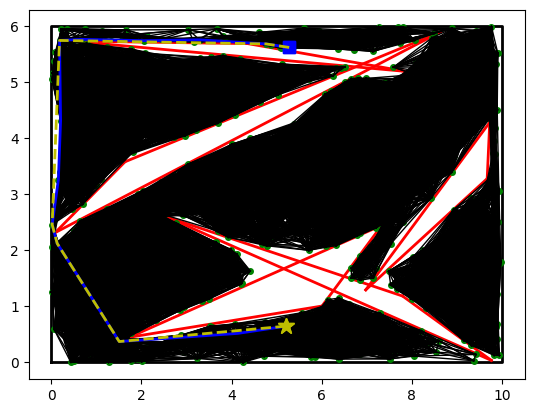

In [11]:
import random
np.random.seed(4)

def path_shortcutting(env, path, maxrep=100):
    """
    Post-process the path by applying shortcuts
    """
    for _ in range(maxrep):
        if len(path) < 3:
            break
        t1, t2 = sorted(random.sample(range(len(path)), 2))
        if t1 == t2:
            continue
        p1, p2 = path[t1], path[t2]
        if not line_collision_check(env, p1[0], p1[1], p2[0], p2[1]):
            path = path[:t1 + 1] + [p2] + path[t2 + 1:]
    return path

def main():
    env = environment_2d.Environment(10, 6, 5)
    pl.clf()
    radius = 1.5
    q = env.random_query()
    if q is not None:
        x_start, y_start, x_goal, y_goal = q
        start, goal = (x_start, y_start), (x_goal, y_goal)
        G, samples = prm_algorithm(env)
        plot_prm(env, G, samples, start, goal)
        
        # Step 3: Find path from start to goal
        if not env.check_collision(start[0], start[1]) and not env.check_collision(goal[0], goal[1]):
            G.add_node(start)
            G.add_node(goal)
            for (x, y) in samples:
                if np.linalg.norm([start[0] - x, start[1] - y]) <= radius:
                    if not line_collision_check(env, start[0], start[1], x, y):
                        G.add_edge(start, (x, y), weight=np.linalg.norm([start[0] - x, start[1] - y]))
                if np.linalg.norm([goal[0] - x, goal[1] - y]) <= radius:
                    if not line_collision_check(env, goal[0], goal[1], x, y):
                        G.add_edge(goal, (x, y), weight=np.linalg.norm([goal[0] - x, goal[1] - y]))
            try:
                path = nx.shortest_path(G, source=start, target=goal, weight='weight')
                path_coords = np.array(path)
                pl.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
                env.plot_query(start[0], start[1], goal[0], goal[1])  # Plot start and goal
                pl.draw()
                
                # Apply path shortcutting
                optimized_path = path_shortcutting(env, path)
                optimized_path_coords = np.array(optimized_path)
                # optimized_path_coords[:, 0]: This extracts all the x-coordinates of the optimized path from the optimized_path_coords array.
                # optimized_path_coords[:, 1]: This extracts all the y-coordinates of the optimized path from the optimized_path_coords array.
                pl.plot(optimized_path_coords[:, 0], optimized_path_coords[:, 1], 'y--', linewidth=2)
                pl.draw()
            except nx.NetworkXNoPath:
                print("No path found")

main()

n_samples = 1000 may be too much for practical use. Trying with n_samples = 450 to see if there's any difference:

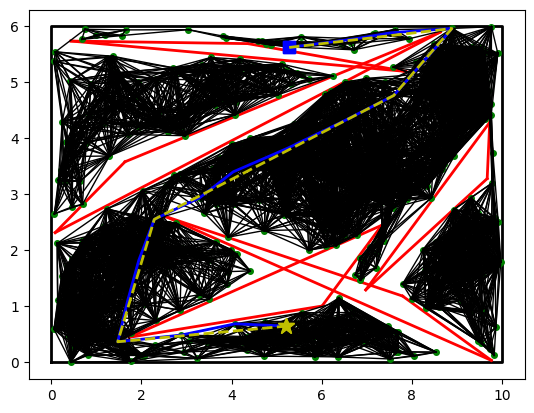

In [13]:
np.random.seed(4)

def main():
    env = environment_2d.Environment(10, 6, 5)
    pl.clf()
    radius = 1.5
    q = env.random_query()
    if q is not None:
        x_start, y_start, x_goal, y_goal = q
        start, goal = (x_start, y_start), (x_goal, y_goal)
        G, samples = prm_algorithm(env, n_samples=450)
        plot_prm(env, G, samples, start, goal)
        
        # Step 3: Find path from start to goal
        if not env.check_collision(start[0], start[1]) and not env.check_collision(goal[0], goal[1]):
            G.add_node(start)
            G.add_node(goal)
            for (x, y) in samples:
                if np.linalg.norm([start[0] - x, start[1] - y]) <= radius:
                    if not line_collision_check(env, start[0], start[1], x, y):
                        G.add_edge(start, (x, y), weight=np.linalg.norm([start[0] - x, start[1] - y]))
                if np.linalg.norm([goal[0] - x, goal[1] - y]) <= radius:
                    if not line_collision_check(env, goal[0], goal[1], x, y):
                        G.add_edge(goal, (x, y), weight=np.linalg.norm([goal[0] - x, goal[1] - y]))
            try:
                path = nx.shortest_path(G, source=start, target=goal, weight='weight')
                path_coords = np.array(path)
                pl.plot(path_coords[:, 0], path_coords[:, 1], 'b-', linewidth=2)
                env.plot_query(start[0], start[1], goal[0], goal[1])  # Plot start and goal
                pl.draw()
                
                # Apply path shortcutting
                optimized_path = path_shortcutting(env, path)
                optimized_path_coords = np.array(optimized_path)
                # optimized_path_coords[:, 0]: This extracts all the x-coordinates of the optimized path from the optimized_path_coords array.
                # optimized_path_coords[:, 1]: This extracts all the y-coordinates of the optimized path from the optimized_path_coords array.
                pl.plot(optimized_path_coords[:, 0], optimized_path_coords[:, 1], 'y--', linewidth=2)
                pl.draw()
            except nx.NetworkXNoPath:
                print("No path found")

main()

Final observations: There is a small difference implementing our own algorithm of shortcutting vs using shortest_path pathfinding by networkx, as it uses dijkstra's algorithm by default. The documentation is here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html

<hr>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=809c658c-7cbd-49c3-b9bd-71f2c4370ecb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>